<a href="https://colab.research.google.com/github/chanu-tha/python_AB_testing_Marketing_Campaign/blob/main/Marketing_AB_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem statement

Zenith Marketing Solutions recently conducted an A/B test to evaluate the effectiveness of a new advertising campaign compared to a public service announcement (PSA) approach.  The control group was exposed to a PSA, while the experimental group was exposed to the new ads. The test has concluded, and the company now needs to determine whether the advertising campaign was successful and, if so, quantify the impact of the ads compared to the PSA.

As a data analyst, the task is to analyze the results of the A/B test and present findings to the Head of Strategy.  The analysis should answer the following key questions:

1. Was the advertising campaign successful?

2. If the campaign was successful, how much of that success can be attributed to the ads?

3. What other relevant insights can be gleaned from the data to support decision-making?


### Interpret the data

This A/B test analyzes the effectiveness of a new marketing campaign.  The primary metric for success is the conversion rate, defined as the users who make a purchase.  I will compare the conversion rates of the control group (exposed to the existing campaign or no campaign) and the treatment group (exposed to the new campaign) to determine if the new campaign yields a statistically significant improvement.

The hypothesis for this test:  
H0 : There is no statiscally significannt difference in conversion rate between control and experimental group.  
Ha : There is a statistically significant difference in conversion rates between the control group and the experimental group.

Significance level (alpha) : 5%

Data dictionary:

- Index: Row index
- user id: User ID (unique)
- test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- converted: If a person bought the product then True, else is False
- total ads: Amount of ads seen by person
- most ads day: Day that the person saw the biggest amount of ads
- most ads hour: Hour of day that the person saw the biggest amount of ads   

In [1]:
## import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from scipy.optimize import minimize

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import confint_proportions_2indep


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


import warnings
warnings.filterwarnings('ignore')

In [2]:
## import data into nb
from google.colab import drive

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab_dataset/Marketing_AB_Test/marketing_AB.csv'

ab_raw = pd.read_csv(file_path)



Mounted at /content/drive


### EDA


In [3]:
# print first5 rows

ab_raw.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [4]:
ab_raw[ab_raw["test group"] == "psa"].head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
18,18,900681,psa,False,248,Saturday,19
38,38,905704,psa,False,27,Thursday,8
68,68,904595,psa,False,13,Tuesday,19
140,140,901904,psa,False,32,Wednesday,19
157,157,902234,psa,False,105,Tuesday,19


In [5]:
## check df info

ab_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


 The dataset contained no missing values.

**Checking for duplicate value**

In [6]:
## check duplicate
ab_raw.duplicated().sum()

0

There is no duplicate value.

In [7]:
## Drop unwanted column

ab_raw.drop("Unnamed: 0", axis = 1, inplace = True)


In [8]:
ab_raw.columns

Index(['user id', 'test group', 'converted', 'total ads', 'most ads day',
       'most ads hour'],
      dtype='object')

In [9]:
ab_raw.rename(columns={
    'user id': 'user_id',
    'test group': 'test_group',
    'total ads': 'total_ads',
    'most ads day': 'most_ads_day',
    'most ads hour': 'most_ads_hour'
}, inplace=True)

**Check the consistency of the data**

In [10]:
## check the level of categorical variables

ab_cat = ab_raw[["test_group", "converted", "most_ads_day", "most_ads_hour" ]]
ab_cat.nunique()

,0
test_group,2
converted,2
most_ads_day,7
most_ads_hour,24


In [11]:
## print the value of each categorical variable

for i in ab_cat.columns:
    print(i, ":", ab_cat[i].unique())

test_group : ['ad' 'psa']
converted : [False  True]
most_ads_day : ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
most_ads_hour : [20 22 18 10 14 13 19 11 12 16 21  3 23  4  8  0  2 15  1  6 17  7  9  5]


According to the data dictionary, 'total ads' was the sole numeric variable, representing the total number of ads shown.  All other variables were treated as categorical.  Despite numerical representation, 'most ads hour' was treated as categorical, reflecting the hours of the day.  The 'converted' variable served as the target variable for analysis and was compared against all other variables to assess their influence on conversions.

**Checking outliers**

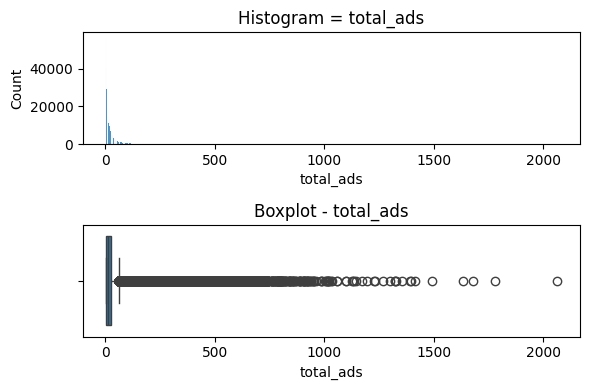

In [12]:
variable = "total_ads"

plt.figure(figsize = (6,4))

# histogram
plt.subplot(2,1,1)
sns.histplot(x = variable, data = ab_raw)
plt.title(f"Histogram = {variable}")

# boxplot
plt.subplot(2,1,2)
sns.boxplot(x = variable, data = ab_raw)
plt.title(f"Boxplot - {variable}")

plt.tight_layout()
plt.show()

From the boxplot, the extreme outliers were observed.

In [13]:
## calculate Q1 and Q3

numeric_col = ab_raw["total_ads"]
q1 = numeric_col.quantile(0.25)
q3 = numeric_col.quantile(0.75)

## calculate IDR, outliers are any point beyond 1.5*IQR from Q1 and Q3
IQR = q3 - q1
upper_bound = q3+(1.5*IQR)
lower_bound = q1-(1.5*IQR)

outliers = ab_raw[(numeric_col < lower_bound) | (numeric_col > upper_bound)]
n_outliers = len(outliers)
n_records = len(ab_raw)
outliers_pct = (n_outliers/n_records)*100

print(f"\nTotal records: {n_records}")
print(f"Total outliers: {n_outliers}")
print(f"Percentage of outliers: {outliers_pct:.2f}%")


Total records: 588101
Total outliers: 52057
Percentage of outliers: 8.85%


The percentage of outliers is more than 5% of total records. If we drop the entire outliers from the record, it might influence the result. Let investigate more whether we can drop the outliers or not.

In [14]:
## outliers filter
ab_no_outlier = ab_raw[~ab_raw.index.isin(outliers.index)]

print("Descriptive Statistics excluding outliers\n")
print(ab_no_outlier["total_ads"].describe())

print("\nDescriptive Statistics including outliers\n")
print(ab_raw["total_ads"].describe())

print("\nDescriptive Statistics of outliers\n")
print(outliers["total_ads"].describe())

Descriptive Statistics excluding outliers

count    536044.000000
mean         15.134015
std          14.063618
min           1.000000
25%           4.000000
50%          11.000000
75%          22.000000
max          61.000000
Name: total_ads, dtype: float64

Descriptive Statistics including outliers

count    588101.000000
mean         24.820876
std          43.715181
min           1.000000
25%           4.000000
50%          13.000000
75%          27.000000
max        2065.000000
Name: total_ads, dtype: float64

Descriptive Statistics of outliers

count    52057.000000
mean       124.568915
std         92.934439
min         62.000000
25%         74.000000
50%         94.000000
75%        136.000000
max       2065.000000
Name: total_ads, dtype: float64


In [15]:
## record with outliers conversion rate

ab_raw.groupby("test_group")["converted"].value_counts(normalize= True).unstack()

converted,False,True
test_group,,
ad,0.974453,0.025547
psa,0.982146,0.017854


In [16]:
## record without outliers conversion rate

ab_no_outlier.groupby("test_group")["converted"].value_counts(normalize = True).unstack()

converted,False,True
test_group,,
ad,0.986616,0.013384
psa,0.989404,0.010596


About 8.8% of our data consists of outliers, which significantly affect the conversion rates we see. To get the most accurate results from our A/B test, we'll analyze the data in two ways: first **without these outliers**, and then **with outliers included**. Removing outliers might underestimate the true conversion rate if those users are genuinely valuable. However, keeping them in might overestimate the impact of our changes. We'll use statistical tests that don't assume the data is perfectly balanced, especially when outliers are included. In the end, we'll look at both the statistical results (like p-values) and the real-world business impact of any differences we find before making recommendations.

Testing Hypothesis without outliers

In [17]:
## remove an outliers

ab_clean = ab_no_outlier.reset_index(drop=True)



In [18]:
conv_rate = ab_clean.groupby("test_group")["converted"].mean()
conv_rate

,converted
test_group,
ad,0.013384
psa,0.010596


In [19]:
## calculate conversion rate
exp_conv_rate = conv_rate[0]
control_conv_rate = conv_rate[1]
abs_lift = exp_conv_rate - control_conv_rate
rel_lift = abs_lift / control_conv_rate

## calculate number of converted users
exp_conv = ab_clean[ab_clean["test_group"] == "ad"]["converted"].sum()
control_conv = ab_clean[ab_clean["test_group"] == "psa"]["converted"].sum()

## calculate size
exp_count = ab_clean.groupby("test_group")["user_id"].count()[0]
control_count = ab_clean.groupby("test_group")["user_id"].count()[1]

## check the sample size for z-test
def check_z_test(n, p):
    return (n*p >= 10) and (n*(1-p) >= 10)

print(check_z_test(exp_count, exp_conv_rate) and check_z_test(control_count, control_conv_rate))

print(f"\nExperimental group conversion rate: {exp_conv_rate:.2%}")
print(f"Control group conversion rate: {control_conv_rate:.2%}")

print(f"\nAbsolute lift : {abs_lift:.2%}")
print(f"Relative lift : {rel_lift:.2%}")


True

Experimental group conversion rate: 1.34%
Control group conversion rate: 1.06%

Absolute lift : 0.28%
Relative lift : 26.31%


Sample sizes are large enough for z-test

The variables are independece



In [20]:
## conduct Two-proportion z-test and calculate confidence interval

alpha = 0.05

def z_test_and_ci(x_exp, x_control, n_exp, n_control):

    z, p_val = proportions_ztest([x_exp, x_control], [n_exp, n_control])


    print(f"Z-statistics: {z}")
    print(f"p-value: {p_val}\n")

    if p_val < alpha:
        print("Reject the null hypothesis. The difference in conversion rates between control and experimental group is statistically significant.")
    else:
        print("Fail to reject the null hypothesis. The difference in conversion rates between control and experimental  is not statistically significant.")

    ci = confint_proportions_2indep(x_exp, n_exp, x_control, n_control)

    ci_rel = ci/(x_control/n_control)

    print(f"95% confidence interval for absolute lift: [{ci[0]:.2%},{ci[1]:.2%}]")
    print(f"95% confidence interval for relative lift: [{ci_rel[0]:.2%},{ci_rel[1]:.2%}]")

In [21]:
z_test_and_ci(exp_conv, control_conv, exp_count, control_count)

Z-statistics: 3.4859086419622503
p-value: 0.000490468476045044

Reject the null hypothesis. The difference in conversion rates between control and experimental group is statistically significant.
95% confidence interval for absolute lift: [0.13%,0.41%]
95% confidence interval for relative lift: [12.18%,38.83%]


Calculate the effect size

In [22]:
## calculate the effect size

effect_size_cohens = 2*(np.arcsin(np.sqrt(exp_conv_rate))- np.arcsin(np.sqrt(control_conv_rate)))

def effect_size_result(h):
    if  abs(h) < 0.2:
        return "Small effect"
    elif abs(h) < 0.5:
        return "Medium effect"
    else:
        return "Large effect"

print(f"Cohen's : {effect_size_cohens:.4f} ({effect_size_result(effect_size_cohens)})")


Cohen's : 0.0257 (Small effect)


The A/B test results show a statistically significant increase in conversion rate for users who see the ads compared to those who do not.  This confirms our null hypothesis that there is a difference.  The 95% confidence interval for the actual lift is 0.13% - 0.41%.  However, Cohen's d indicates a small effect size (0.0257), suggesting that the practical impact of the ads on the conversion rate is minimal.

Therefore, the decision to implement this campaign hinges on a cost-benefit analysis.  We need to determine if the projected increase in conversions, even as small as 0.13%, justifies the costs associated with running the ads.

### Testing hypothesis with outliers

In [23]:
conv_rate_raw = ab_raw.groupby("test_group")["converted"].mean()
conv_rate_raw

,converted
test_group,
ad,0.025547
psa,0.017854


In [24]:
exp_raw_conv_rate = conv_rate_raw[0]
control_raw_conv_rate = conv_rate_raw[1]
abs_raw_lift = exp_raw_conv_rate - control_raw_conv_rate
rel_raw_lift = abs_lift / control_raw_conv_rate

## calculate number of converted users
exp_raw_conv = ab_raw[ab_raw["test_group"] == "ad"]["converted"].sum()
control_raw_conv = ab_raw[ab_raw["test_group"] == "psa"]["converted"].sum()

## calculate size
exp_raw_count = ab_raw.groupby("test_group")["user_id"].count()[0]
control_raw_count = ab_raw.groupby("test_group")["user_id"].count()[1]

## check the sample size for z-test

print(check_z_test(exp_raw_count, exp_raw_conv_rate) and check_z_test(control_raw_count, control_raw_conv_rate))

print(f"\nExperimental group conversion rate: {exp_raw_conv_rate:.2%}")
print(f"Control group conversion rate: {control_raw_conv_rate:.2%}")

print(f"\nAbsolute lift : {abs_raw_lift:.2%}")
print(f"Relative lift : {rel_raw_lift:.2%}")


True

Experimental group conversion rate: 2.55%
Control group conversion rate: 1.79%

Absolute lift : 0.77%
Relative lift : 15.61%


In [25]:
## conduct a z-test

z_test_and_ci(exp_raw_conv, control_raw_conv, exp_raw_count, control_raw_count)

Z-statistics: 7.3700781265454145
p-value: 1.7052807161559727e-13

Reject the null hypothesis. The difference in conversion rates between control and experimental group is statistically significant.
95% confidence interval for absolute lift: [0.59%,0.94%]
95% confidence interval for relative lift: [32.90%,52.43%]


In [26]:
## calculate the effect size

raw_effect_size_cohens = 2*(np.arcsin(np.sqrt(exp_raw_conv_rate))- np.arcsin(np.sqrt(control_raw_conv_rate)))

print(f"Cohen's : {raw_effect_size_cohens:.4f} ({effect_size_result(raw_effect_size_cohens)})")


Cohen's : 0.0530 (Small effect)


The A/B test results of the data with outliers result in the similar way, show a statistically significant increase in conversion rate for users who see the ads compared to those who do not.  This confirms our null hypothesis that there is a difference.  The 95% confidence interval for the actual lift is 0.59% - 0.94%.  However, Cohen's d indicates a small effect size (0.0530), suggesting that the practical impact of the ads on the conversion rate is minimal.


|Feature	|Test 1 (Outliers Removed)	|Test 2 (Outliers Included)|
|-----|-----|-----|
|Statistical Significance	|Significant	|Significant|
|Actual Lift (95% CI)|	0.13% - 0.41%	|0.59% - 0.94%|
|Cohen's d	|0.0257 (small)|	0.0530 (small)|

In [27]:
outliers["total_ads"].describe()

,total_ads
count,52057.000000
mean,124.568915
std,92.934439
min,62.000000
25%,74.000000
50%,94.000000
75%,136.000000
max,2065.000000


In [28]:
ab_raw_desc = ab_raw["total_ads"].agg(["mean","min","max"]).reset_index()

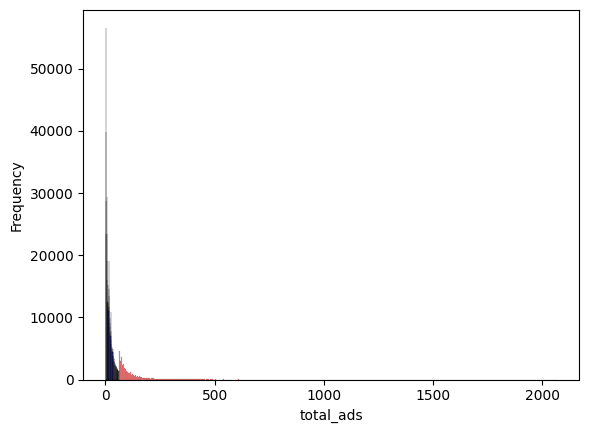

In [29]:
##

sns.histplot(ab_no_outlier["total_ads"],alpha = 0.5, color = "blue")
sns.histplot(outliers["total_ads"],alpha= 0.5, color = "red")
plt.xlabel("total_ads")
plt.ylabel("Frequency")
plt.show()

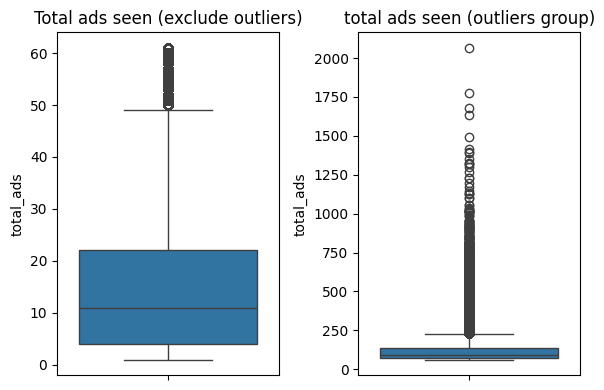

In [30]:
##

fig, axes = plt.subplots(1,2, figsize=(6,4))

sns.boxplot(data = ab_no_outlier, y = "total_ads", ax=axes[0])
axes[0].set_title("Total ads seen (exclude outliers)")

sns.boxplot(data = outliers, y="total_ads", ax = axes[1])
axes[1].set_title("total ads seen (outliers group)")

plt.tight_layout()
plt.show()

Test conversion vs total ads

In [31]:

def summarize_numeric_column(dataframes, column_name):

    if not dataframes:  # Check if the dictionary is empty
        return pd.DataFrame()

    summary_data = {}
    for name, df in dataframes.items():
        if not isinstance(df, pd.DataFrame): # Check if it is a dataframe
            print(f"Warning: Data associated with '{name}' is not a Pandas DataFrame. Skipping.")
            continue

        if column_name not in df.columns:
            print(f"Warning: Column '{column_name}' not found in DataFrame '{name}'. Skipping.")
            continue

        try:
            summary_data[name] = {
                'min': df[column_name].min(),
                'mean': df[column_name].mean(),
                'max': df[column_name].max()
            }
        except TypeError: # This handles cases where the column is not numeric.
            print(f"Warning: Column '{column_name}' in DataFrame '{name}' is not numeric. Skipping.")
            continue

    if not summary_data: # If no valid data was found
        return pd.DataFrame()

    summary_df = pd.DataFrame.from_dict(summary_data, orient='index') # More efficient for this structure.
    return summary_df.T

In [32]:
conv_outliers_rate = outliers.groupby("test_group")["converted"].mean()

In [33]:
"""
ab_raw: conv_rate_raw
ab_clean: conv_rate
outliers: conv_outliers_rate
"""

'\nab_raw: conv_rate_raw\nab_clean: conv_rate\noutliers: conv_outliers_rate\n'

In [34]:


conversion_table = {
    'ads_group' : [conv_rate_raw[0], conv_rate[0], conv_outliers_rate[0]],
    'psa_group' : [conv_rate_raw[1], conv_rate[1], conv_outliers_rate[1]],
    'overall'   : [ab_raw["converted"].mean(), ab_clean["converted"].mean(), outliers["converted"].mean()]
}

conversion_data = pd.DataFrame(conversion_table, index=["with outliers", "no outliers", "outliers group"])


conversion_agg = conversion_data.mul(100).T.round(2)

In [35]:
dataframes = {'no outliers': ab_clean, 'with outliers': ab_raw, 'outliers group': outliers}


summary_stats = summarize_numeric_column(dataframes, "total_ads")

In [36]:
summary_desc = pd.concat([summary_stats, conversion_agg])

print(summary_desc)

           no outliers  with outliers  outliers group
min           1.000000       1.000000       62.000000
mean         15.134015      24.820876      124.568915
max          61.000000    2065.000000     2065.000000
ads_group     1.340000       2.550000       15.110000
psa_group     1.060000       1.790000        8.830000
overall       1.330000       2.520000       14.850000


- The conversion rate for outliers (14.85%) is disproportionately high compared to the overall conversion rate (2.52%) and the rate without outliers (1.33%).
- The overall average ads seen (24.82) is significantly higher than the average without outliers (15.13). This indicates that outliers heavily skew the data.
- Outliers have an average of 124.57 ads seen, much higher than the overall average. Their behavior (high conversion rate and ad views) is fundamentally different from the majority of the data.  

Analysis of the A/B test data revealed a significant influence of outliers on conversion rates.  Outliers exhibited a disproportionately high conversion rate of 14.85%, compared to the overall rate of 2.52% and the rate excluding outliers of just 1.33%.  This skewing effect is further evidenced by the average number of ads seen: outliers averaged 124.57 ads, dramatically higher than the overall average of 24.82 and the average excluding outliers of 15.13.  These findings suggest that outliers represent a distinct user segment with fundamentally different behavior.

Although the A/B test showed the new campaign improved conversions even with outliers included, the outliers' huge impact on overall conversion rates needs further study.  Their unique behavior—whether from real users or anomalies  separate analysis and targeted strategies.  So, the following recommendations and analysis will focus on data without outliers to better understand typical user behavior.

###Conclusion
The campaign is projected to increase revenue by 12.18% to 38.83%.  However, to fully evaluate the campaign's potential and provide actionable recommendations, I would request further information on revenue per conversion and implementation costs in order to perform cost-benefit analysis.  Understanding these factors will allow me to calculate the return on investment (ROI) and determine the campaign's true profitability.  My next steps will be to conduct this analysis upon receiving the necessary data.  Furthermore, exploring potential ads optimization strategies during implementation could further enhance the campaign's ROI.

### Additional Analysis

**Find the optimal ads exposure**

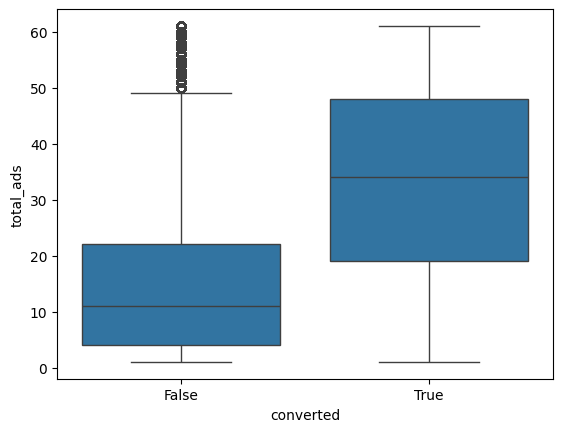

In [37]:


sns.boxplot(x = "converted", y="total_ads", data=ab_clean)
plt.show()

In [38]:
# Check assumption
# normality assumption

def normality_check(df, target_col, num_col):
    shapiro_stat_t, shapiro_p_val_t = shapiro(df[df[target_col] == True][num_col])
    shapiro_stat_f, shapiro_p_val_f = shapiro(df[df[target_col] == False][num_col])

    print(f"Shapiro-Wilk test for normality (True) : p-value is {shapiro_p_val_t}" )
    print(f"Shapiro-Wilk test for normality (False) : p-value is {shapiro_p_val_f}" )

    # Equality of variances assumption
    levene_stat, levene_p_value = levene(df[df[target_col] == True][num_col],df[df[target_col]== False][num_col] )
    print(f"Levene's test for equality of variances: p-value is {levene_p_value}")

    return shapiro_p_val_t, shapiro_p_val_f, levene_p_value

numeric_rel_test = normality_check(ab_clean, "converted", "total_ads")


Shapiro-Wilk test for normality (True) : p-value is 2.1683994738154512e-40
Shapiro-Wilk test for normality (False) : p-value is 6.613246646125758e-155
Levene's test for equality of variances: p-value is 2.957180536335777e-265


**Calcualte the p-value**

In [39]:
# Check for suitable test
alpha = 0.05

# zip value
shapiro_p_val_t, shapiro_p_val_f, levene_p_value = numeric_rel_test


if shapiro_p_val_t > alpha and shapiro_p_val_f > alpha and levene_p_value > alpha:
    ## assumption met, parametric - use t-test for means
    t_stat, t_p_val = ttest_ind(ab_raw[ab_raw["converted"] == True]["total_ads"], ab_raw[ab_raw["converted"] == False]["total_ads"])
    print(f"Independent two-sample t-test: p-value is {t_p_val}\n")

    ## Null hypothesis result
    if t_p_val < alpha:
        print("There is a statistically significant relationship between the number of ads a user is exposed to and conversion rate (Reject the null hypothesis)")
    else:
        print("There is no statistically significant relationship between the number of ads a user is exposed to and conversion rate (Fail to reject the null hypothesis)")
else:
    ## assumptioin not met, non-parametric - use MWU test for median
    u_stat, u_p_val = mannwhitneyu(ab_raw[ab_raw["converted"] == True]["total_ads"], ab_raw[ab_raw["converted"] == False]["total_ads"])
    print(f"Mann-Whitney U test: p-value is {u_p_val}\n")

    ## Null hypothesis result
    if u_p_val < alpha:
        print("There is a statistically significant relationship between the number of ads a user is exposed to and conversion rate (Reject the null hypothesis)")
    else:
        print("There is no statistically significant relationship between the number of ads a user is exposed to and conversion rate (Fail to reject the null hypothesis)")



Mann-Whitney U test: p-value is 0.0

There is a statistically significant relationship between the number of ads a user is exposed to and conversion rate (Reject the null hypothesis)


Find the optimal number of ads exposure

In [40]:
## split the data

X_ads = ab_clean[ab_clean["test_group"] == "ad"][["total_ads"]]
y_ads = ab_clean[ab_clean["test_group"] == "ad"]["converted"]

## Train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ads, y_ads, test_size = 0.2, random_state = 42)

## Fit logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Coefficient :",model.coef_)
print("Intercept :", model.intercept_)


Coefficient : [[0.06379044]]
Intercept : [-5.77952668]


In [41]:
## Evaluation

## Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

## ROC-AUC score
y_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC score: {roc_auc}")

Accuracy: 0.99
ROC-AUC score: 0.7994280637245474


Logistic Regression Model Summary:
Intercept (β₀): -5.7836
Coefficient for total_ads (β₁): 0.0639

Data Summary:
Minimum ads: 1
Maximum ads: 61
Average ads: 15.16
Note: Calculated optimal point (90.46) is above maximum ads in data.

Optimal Ad Exposure Analysis:
Optimal number of ads: 61.00
Conversion probability at optimal point: 0.1320
Marginal return at optimal point: 0.0073

Reference Points:
At 5 ads: Probability = 0.0042, Marginal Return = 0.0003
At 10 ads: Probability = 0.0058, Marginal Return = 0.0004
At 20 ads: Probability = 0.0109, Marginal Return = 0.0007
At 30 ads: Probability = 0.0205, Marginal Return = 0.0013
At 40 ads: Probability = 0.0382, Marginal Return = 0.0023


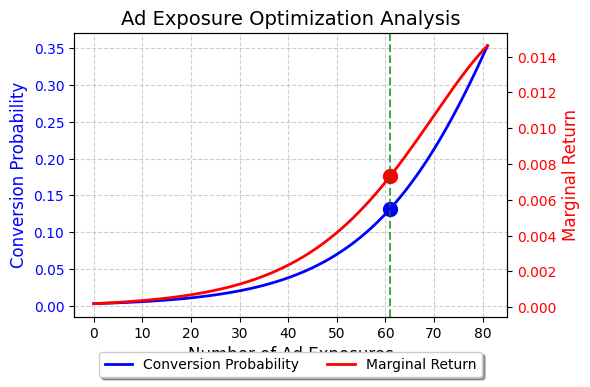

In [42]:
## Find the optimal ads exposure

# Step 1: Fit the logistic regression model
def fit_logistic_regression(X_ads, y_ads):
    """
    Fit a logistic regression model to predict conversion based on ad exposures.

    Parameters:
        X_ads: DataFrame containing 'total_ads' as the independent variable
        y_ads: Series containing 'converted' (1/0) as the dependent variable

    Returns:
        fitted model and summary of model parameters
    """
    # Create and fit the model
    model = LogisticRegression(solver='liblinear')
    model.fit(X_ads, y_ads)

    # Extract model parameters
    intercept = model.intercept_[0]
    coefficient = model.coef_[0][0]

    # Print model summary
    print("Logistic Regression Model Summary:")
    print(f"Intercept (β₀): {intercept:.4f}")
    print(f"Coefficient for total_ads (β₁): {coefficient:.4f}")

    return model, intercept, coefficient

# Step 2: Define functions to calculate conversion probability and marginal return
def conversion_probability(x, intercept, coefficient):
    """Calculate the probability of conversion using the logistic function."""
    return 1 / (1 + np.exp(-(intercept + coefficient * x)))

def marginal_return(x, intercept, coefficient):
    """Calculate the marginal return (derivative of the logistic function)."""
    return coefficient * np.exp(intercept + coefficient * x) / (1 + np.exp(intercept + coefficient * x))**2

# Step 3: Find the optimal number of ad exposures
def find_optimal_exposure(intercept, coefficient, min_ads, max_ads):
    """
    Find the optimal number of ad exposures.

    For a logistic curve, the inflection point (where the curve changes from
    accelerating to decelerating) is at -intercept/coefficient.
    """
    # Mathematical solution for inflection point of logistic curve
    optimal_ads = -intercept / coefficient

    # Check if this is within our data range
    if optimal_ads < min_ads:
        print(f"Note: Calculated optimal point ({optimal_ads:.2f}) is below minimum ads in data.")
        optimal_ads = min_ads
    elif optimal_ads > max_ads:
        print(f"Note: Calculated optimal point ({optimal_ads:.2f}) is above maximum ads in data.")
        optimal_ads = max_ads

    # Calculate values at optimal point
    optimal_prob = conversion_probability(optimal_ads, intercept, coefficient)
    optimal_marg_return = marginal_return(optimal_ads, intercept, coefficient)

    print("\nOptimal Ad Exposure Analysis:")
    print(f"Optimal number of ads: {optimal_ads:.2f}")
    print(f"Conversion probability at optimal point: {optimal_prob:.4f}")
    print(f"Marginal return at optimal point: {optimal_marg_return:.4f}")

    return optimal_ads

# Step 4: Create visualization of conversion probability and marginal returns
def plot_ad_optimization(intercept, coefficient, min_ads, max_ads, optimal_ads):
    """
    Create a visualization showing conversion probability,
    marginal returns, and the optimal point.
    """
    # Create a range of values to plot
    # Extend the range to see the full curve behavior
    extended_min = max(0, min_ads - 5)
    extended_max = max_ads + 20
    x_range = np.linspace(extended_min, extended_max, 1000)

    # Calculate values for both curves
    y_prob = [conversion_probability(x, intercept, coefficient) for x in x_range]
    y_marginal = [marginal_return(x, intercept, coefficient) for x in x_range]

    # Create plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot conversion probability
    ax1.set_xlabel('Number of Ad Exposures', fontsize=12)
    ax1.set_ylabel('Conversion Probability', color='blue', fontsize=12)
    ax1.plot(x_range, y_prob, 'b-', linewidth=2, label='Conversion Probability')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Create second y-axis and plot marginal returns
    ax2 = ax1.twinx()
    ax2.set_ylabel('Marginal Return', color='red', fontsize=12)
    ax2.plot(x_range, y_marginal, 'r-', linewidth=2, label='Marginal Return')
    ax2.tick_params(axis='y', labelcolor='red')

    # Mark the optimal point on both curves
    opt_prob = conversion_probability(optimal_ads, intercept, coefficient)
    opt_marginal = marginal_return(optimal_ads, intercept, coefficient)

    ax1.plot(optimal_ads, opt_prob, 'bo', markersize=10)
    ax2.plot(optimal_ads, opt_marginal, 'ro', markersize=10)

    # Add vertical line at optimal point
    plt.axvline(x=optimal_ads, linestyle='--', color='green', alpha=0.7)

    # Add annotation for optimal point
    plt.annotate(f'Optimal: {optimal_ads:.1f} ads',
                xy=(optimal_ads, opt_prob),
                xytext=(optimal_ads + 5, opt_prob + 0.05),
                arrowprops=dict(facecolor='black', width=1, headwidth=7, alpha=0.7),
                fontsize=12)

    # Add title and legend
    plt.title('Ad Exposure Optimization Analysis', fontsize=14)

    # Create custom legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center',
              bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)

    plt.tight_layout()
    return fig

# Step 5: Run the complete analysis
def run_ad_optimization_analysis(X_ads, y_ads):
    """
    Run the complete ad optimization analysis from data to visualization.
    """
    # Step 1: Fit logistic regression model
    model, intercept, coefficient = fit_logistic_regression(X_ads, y_ads)

    # Get data range
    min_ads = X_ads['total_ads'].min()
    max_ads = X_ads['total_ads'].max()
    mean_ads = X_ads['total_ads'].mean()

    print(f"\nData Summary:")
    print(f"Minimum ads: {min_ads}")
    print(f"Maximum ads: {max_ads}")
    print(f"Average ads: {mean_ads:.2f}")

    # Step 3: Find optimal number of ad exposures
    optimal_ads = find_optimal_exposure(intercept, coefficient, min_ads, max_ads)

    # Step 4: Create and display visualization
    fig = plot_ad_optimization(intercept, coefficient, min_ads, max_ads, optimal_ads)

    # Additional points for reference
    print("\nReference Points:")
    for ads in [5, 10, 20, 30, 40]:
        if min_ads <= ads <= max_ads:
            prob = conversion_probability(ads, intercept, coefficient)
            marg = marginal_return(ads, intercept, coefficient)
            print(f"At {ads} ads: Probability = {prob:.4f}, Marginal Return = {marg:.4f}")

    plt.show()
    return model, optimal_ads, fig

# Run the analysis with your data
model, optimal_ads, fig = run_ad_optimization_analysis(X_ads, y_ads)

Based on our analysis of how ads affect customer conversion, I can share some straightforward insights:  


1. More ads do lead to more conversions - There's a clear positive relationship between showing more ads and increasing the likelihood that someone will convert.
2. We haven't reached our "sweet spot" yet - Our analysis shows that the ideal number of ads would be around 90, but we've only tested up to 61 ads per customer.
3. We're still in the growth phase - Each additional ad we show is actually becoming MORE effective, not less effective. This is unusual and suggests we're still in the early part of the relationship curve.

What This Means in Practice

At 30 ads: About 2% conversion rate
At 40 ads: About 3.8% conversion rate
At 61 ads (our current maximum): About 13.2% conversion rate

The numbers show that our conversion rate more than triples when we increase from 30 to 61 ads.
Recommendations

Test higher ad frequencies - Since we haven't reached the point of diminishing returns, we should experiment with showing more ads (perhaps up to 70-80) to see if conversions continue to climb significantly.
Monitor customer experience - While more ads drive conversions, we should make sure we're not harming the customer experience or creating ad fatigue.
Start with 40+ ads - Even if we can't go all the way to 61, increasing from our current average (15 ads) to 40 ads should substantially improve conversion rates.

The data suggests we still have room to grow with our ad strategy before efficiency starts to decline.

Univariate Analysis

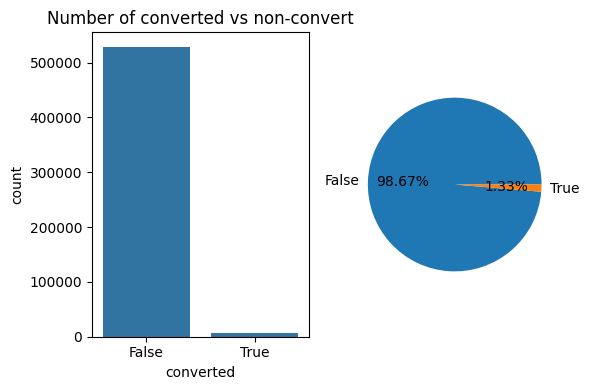

In [57]:

plt.figure(figsize = (6,4))

# count plot
plt.subplot(1,2,1)
sns.countplot(x = "converted", data = ab_clean)
plt.title(f"Number of converted vs non-convert")

# pie chart
plt.subplot(1,2,2)
counts = ab_clean["converted"].value_counts()
plt.pie(counts, labels=counts.index, autopct = "%0.2f%%")


plt.tight_layout()
plt.show()

The overall conversion rate is 1.33%

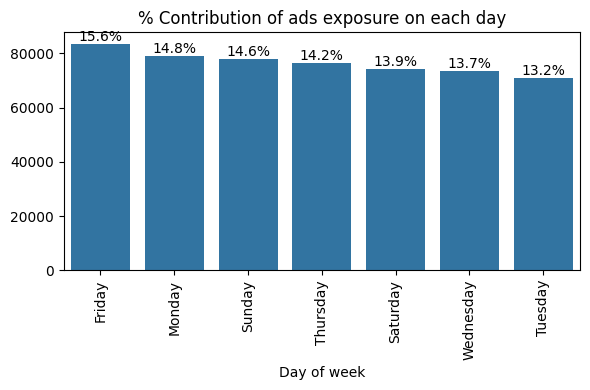

In [62]:


plt.figure(figsize = (6,4))

# count plot
ax = sns.countplot(x = "most_ads_day", data = ab_clean, order = ab_clean["most_ads_day"].value_counts().index)
plt.title(f"% Contribution of ads exposure on each day")
plt.xlabel("Day of week")
plt.ylabel("")
plt.xticks(rotation = 90)

# Add percentage annotations
total = len(ab_clean["most_ads_day"])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2.
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

The distribution is relatively even across the days, with Friday being the day most users (15.75%) saw the most ads.




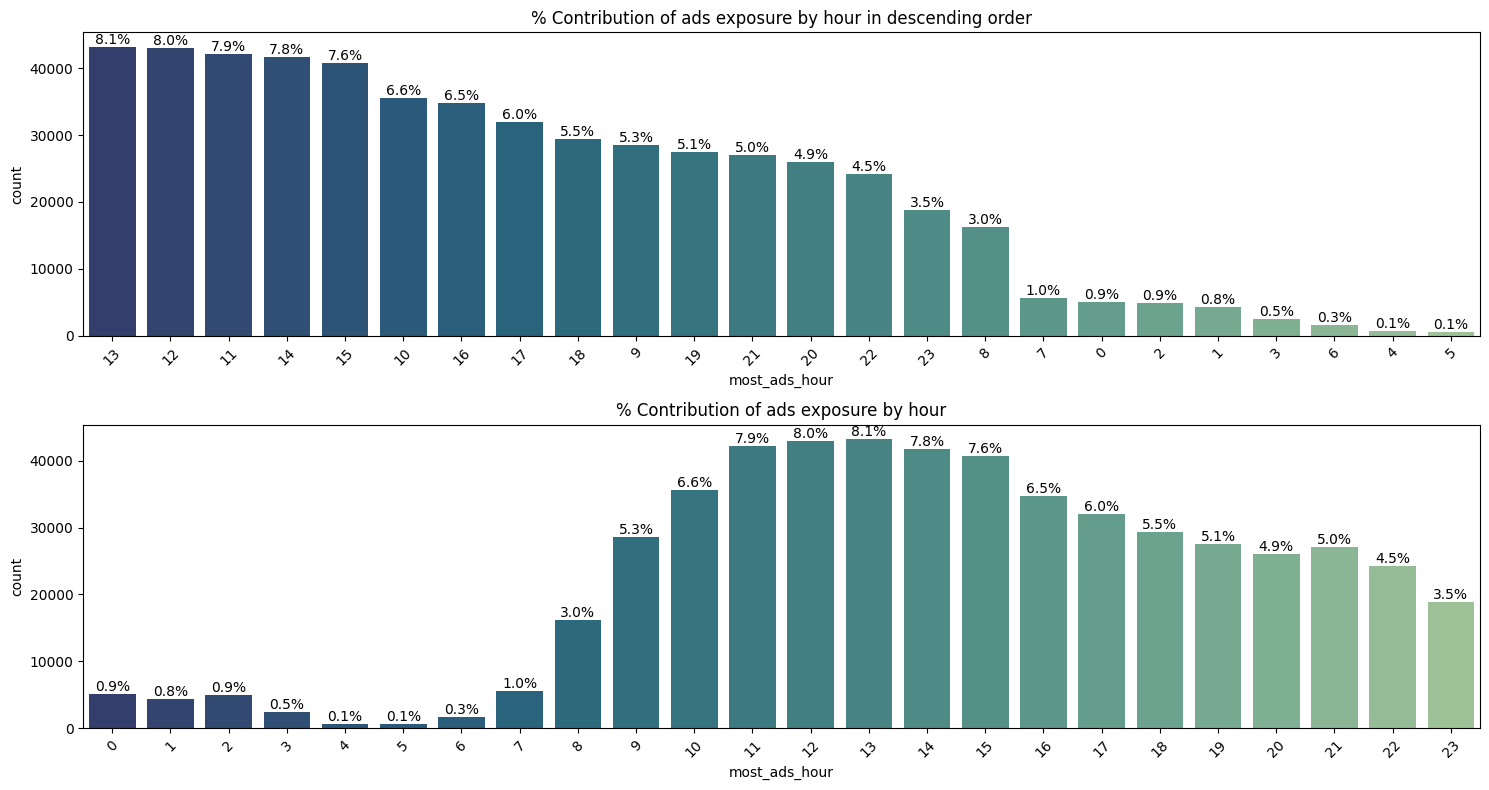

In [63]:


variable = "most_ads_hour"

plt.figure(figsize=(15, 8))  # Adjusted figure size for two subplots

# Subplot 1: Ads hour rank by desc order
plt.subplot(2, 1, 1)
ax1 = sns.countplot(x=variable, data=ab_clean, order=ab_clean["most_ads_hour"].value_counts().index, palette="crest_r")
plt.title(f"% Contribution of ads exposure by hour in descending order")
plt.xticks(rotation=45)

# Add percentage annotations for subplot 1
total = len(ab_clean[variable])
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    ax1.annotate(percentage, (x, y), ha='center', va='bottom')

# Subplot 2: Ads hour rank by hour
plt.subplot(2, 1, 2)
ax2 = sns.countplot(x=variable, data=ab_clean, palette="crest_r")
plt.title("% Contribution of ads exposure by hour")
plt.xticks(rotation=45)

# Add percentage annotations for subplot 2
total = len(ab_clean[variable])
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    ax2.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Users have more parcipitation with ads during 11-15.

**Bivariate Analysis**

In [46]:
## compare test group to converted

conv_rate_test_group = pd.crosstab(ab_clean["test_group"], ab_clean["converted"], normalize = "index")
print(conv_rate_test_group)

converted      False     True 
test_group                    
ad          0.986616  0.013384
psa         0.989404  0.010596


<Axes: xlabel='test_group'>

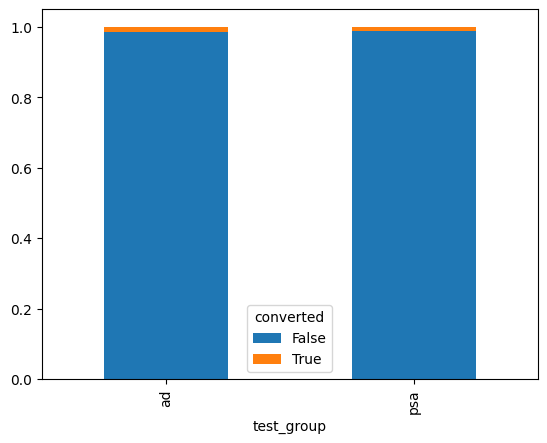

In [47]:
## plot columns chart

conv_rate_test_group.plot.bar(stacked = True)

1.3 % of people who see ads have converted  
1.05 % of people who see psa have converted

In [48]:
overall_conv_rate = ab_clean["converted"].mean()*100
print(overall_conv_rate)

1.3273164143241973


**Statistical Test**

In [55]:
alpha = 0.05

for var in ab_cat.columns:
    if var != "converted":
        # create a contingency table
        contingency_table = pd.crosstab(ab_cat[var], ab_cat["converted"])

        # perform chi2 test
        chi2, p, _, _ = chi2_contingency(contingency_table) #ignore dof and frequency

        # result
        print(f"\nChi-squared test for {var} vs. converted:")
        print(f"Chi-square value: {chi2}")
        print(f"p-value: {p}")

        # significance test
        if p < alpha:
            print(f"There is a significance difference in conversion rate across {var}.")
        else:
            print(f"There is no difference in conversion rate across {var}")




Chi-squared test for test_group vs. converted:
Chi-square value: 54.005823883685245
p-value: 1.9989623063390075e-13
There is a significance difference in conversion rate across test_group.

Chi-squared test for most_ads_day vs. converted:
Chi-square value: 410.0478857936585
p-value: 1.932184379244731e-85
There is a significance difference in conversion rate across most_ads_day.

Chi-squared test for most_ads_hour vs. converted:
Chi-square value: 430.76869230822086
p-value: 8.027629823696771e-77
There is a significance difference in conversion rate across most_ads_hour.


**Conversion vs. Day of week**

converted         False     True 
most_ads_day                     
Monday        98.270062  1.729938
Tuesday       98.442592  1.557408
Sunday        98.688983  1.311017
Wednesday     98.704473  1.295527
Friday        98.818549  1.181451
Thursday      98.847157  1.152843
Saturday      98.928154  1.071846


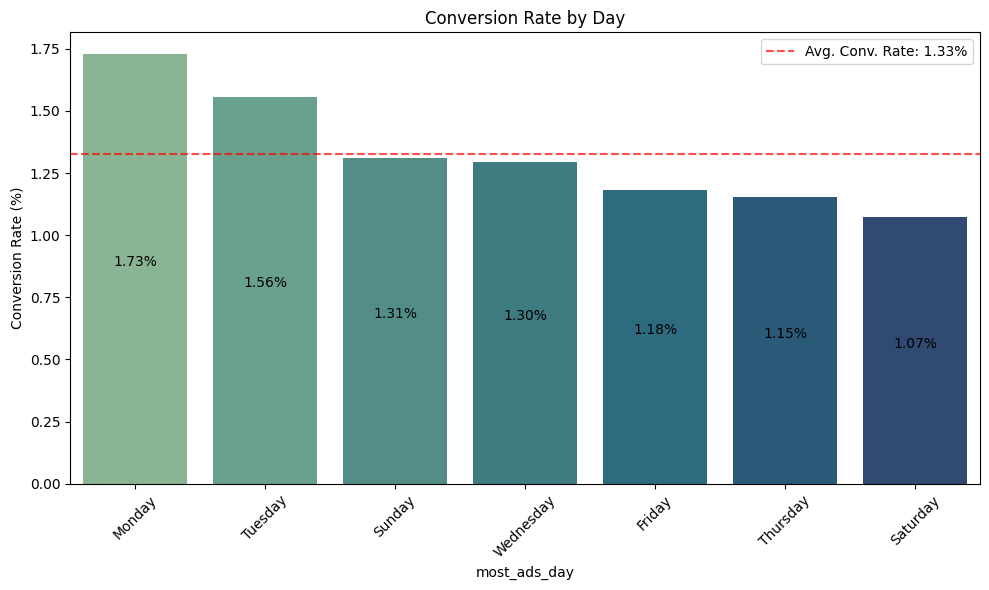

In [49]:


# Calculate conversion rates
conv_rate_ads_day = pd.crosstab(ab_clean["most_ads_day"], ab_clean["converted"], normalize='index').mul(100)
conv_rate_ads_day_srt = conv_rate_ads_day.sort_values(by= True, ascending=False)
print(conv_rate_ads_day_srt)

# Melt the DataFrame for seaborn
melted_data = conv_rate_ads_day.melt(value_name='Percentage', ignore_index=False)
melted_data.index.name = 'most_ads_day'
melted_data.reset_index(inplace=True)


plt.figure(figsize=(10, 6))
ax = sns.barplot(x='most_ads_day', y='Percentage', data=melted_data[melted_data["converted"] == True], palette='crest', order= conv_rate_ads_day_srt.index)
plt.title('Conversion Rate by Day')
plt.ylabel('Conversion Rate (%)')

plt.xticks(rotation=45)
ax.axhline(y=overall_conv_rate, linestyle='--', alpha=0.7, color='red', label=f'Avg. Conv. Rate: {overall_conv_rate:.2f}%')

# Add percentage annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Only label non-zero values
        ax.annotate(f'{height:.2f}%', (x + width/2, y + height/2), ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

Mondays and Tuesdays are the most effective days for conversions, showing significantly higher conversion rates than the weekly average.  In contrast, Sundays and Wednesdays closely mirror the average conversion rate, indicating these days are less impactful for driving conversions. This suggests that focusing our efforts on Mondays and Tuesdays could yield the highest return on investment

**Coversion vs. Hour of the day**

In [50]:
## compare ads hour to converted

conv_rate_ads_hour = pd.crosstab(ab_clean["most_ads_hour"], ab_clean["converted"], normalize = "index").mul(100)
print(conv_rate_ads_hour.sort_values(by = True, ascending= False))

converted          False     True 
most_ads_hour                     
16             98.355794  1.644206
20             98.394099  1.605901
22             98.473408  1.526592
17             98.487784  1.512216
21             98.494210  1.505790
15             98.503906  1.496094
14             98.540303  1.459697
18             98.589438  1.410562
19             98.622519  1.377481
23             98.679115  1.320885
6              98.731118  1.268882
13             98.740886  1.259114
12             98.747322  1.252678
0              98.877511  1.122489
10             98.892356  1.107644
11             98.894634  1.105366
7              98.925886  1.074114
9              98.980021  1.019979
5              99.027553  0.972447
4              99.038462  0.961538
8              99.054154  0.945846
1              99.262673  0.737327
3              99.393204  0.606796
2              99.552208  0.447792


In [51]:
hour_conv_rate = ab_clean.groupby("most_ads_hour")["converted"].mean()
overall_hour_conv_rate = hour_conv_rate.mean()*100
print(overall_hour_conv_rate)

hourly_conv = ab_clean.groupby('most_ads_hour').agg({'converted': 'mean'}).round(3).reset_index()

1.1975597836885186


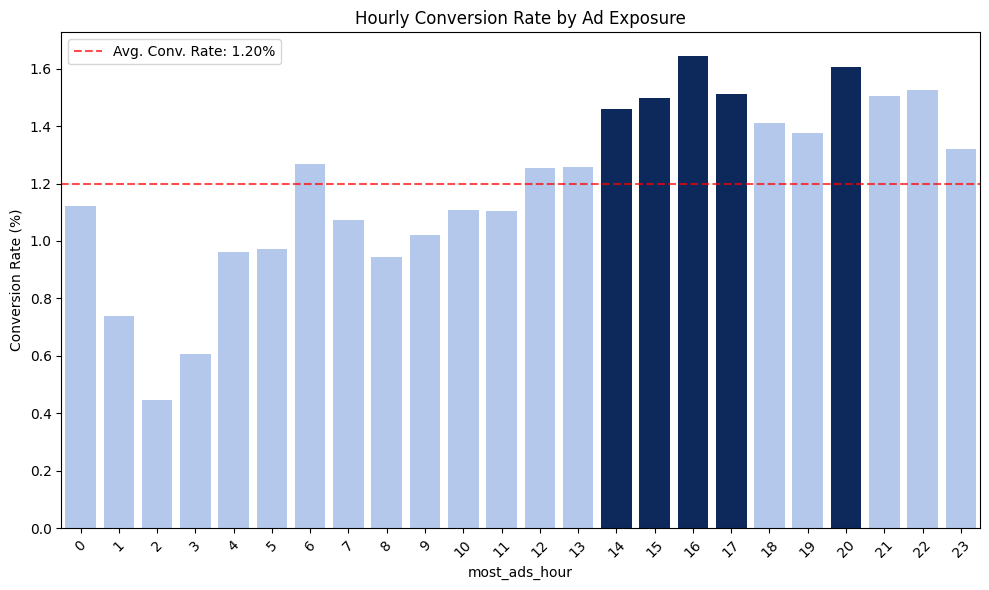

In [52]:


# Calculate conversion rates
conv_rate_ads_hour = pd.crosstab(ab_clean["most_ads_hour"], ab_clean["converted"], normalize='index').mul(100)

# set 5 n largest

top_5_hours = hourly_conv.nlargest(5, 'converted')['most_ads_hour']
colors_5n = ["#002569" if x in top_5_hours.values else "#abc5f5" for x in hourly_conv['most_ads_hour']]


# Melt the DataFrame for seaborn
hour_data = conv_rate_ads_hour.melt(value_name='Percentage', ignore_index=False)
hour_data.index.name = 'most_ads_hour'
hour_data.reset_index(inplace=True)


plt.figure(figsize=(10, 6))
ax = sns.barplot(x='most_ads_hour', y='Percentage', data=hour_data[hour_data["converted"] == True],palette=colors_5n)
plt.title('Hourly Conversion Rate by Ad Exposure')
plt.ylabel('Conversion Rate (%)')

plt.xticks(rotation=45)
ax.axhline(y=overall_hour_conv_rate, linestyle='--', alpha=0.7, color='red', label=f'Avg. Conv. Rate: {overall_hour_conv_rate:.2f}%')

# Add percentage annotations
'''for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Only label non-zero values
        ax.annotate(f'{height:.2f}%', (x + width/2, y + height/2), ha='center', va='bottom', rotation = 90)'''


plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

We see the most conversions in the afternoon and evening (2 PM to 9 PM), peaking at 4 PM with a 1.6% rate, which is higher than our average. Early mornings (1 AM to 4 AM) are the worst, especially 2 AM with only 0.45%.  Interestingly, we also see a smaller spike around 6 AM.  People likely convert more during leisure time. To get the best results, focus ad spending between 2 PM and 9 PM, cut back in early mornings, and keep some ads running around 6 AM.

**Hourly conversion rate on Monday and Tuesday by hour of the day**

In [53]:
conv_rate_by_day_hour = ab_clean.groupby(["most_ads_day", "most_ads_hour"]).agg({"converted" : "mean"}).reset_index()
conv_rate_by_day_hour["converted"] = conv_rate_by_day_hour["converted"]*100

'''
print(ab_clean.head(),"\n")
print(conv_rate_by_day_hour.head())
print(hour_data.head()) '''

'\nprint(ab_clean.head(),"\n")\nprint(conv_rate_by_day_hour.head())\nprint(hour_data.head()) '

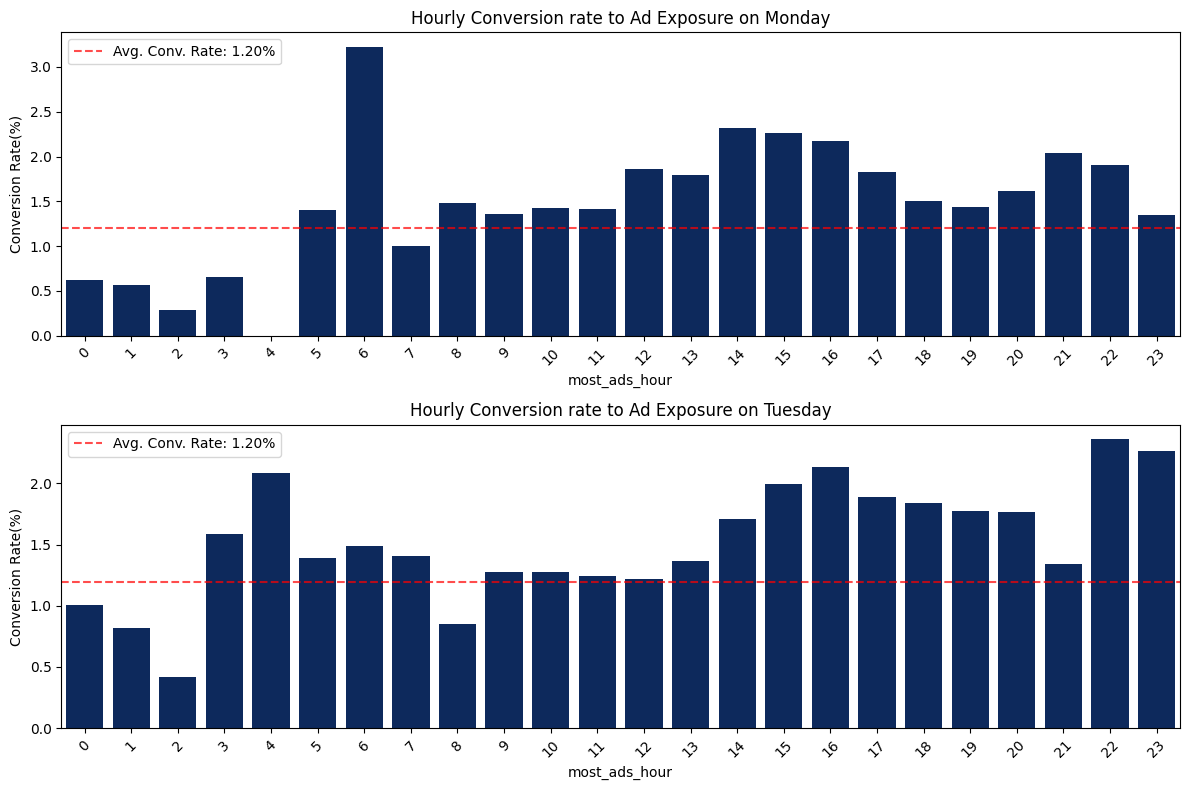

In [54]:


def plot_conversion_rate(data, day, ax):
    """Plots the conversion rate by hour for a given day."""
    sns.barplot(data=data[data["most_ads_day"] == day], x="most_ads_hour", y="converted", ax=ax, color = "#002569" )
    ax.axhline(y=overall_hour_conv_rate, linestyle='--', alpha=0.7, color='red', label=f'Avg. Conv. Rate: {overall_hour_conv_rate:.2f}%')
    ax.legend(loc="upper left")
    ax.set_ylabel("Conversion Rate(%)")
    ax.set_title(f"Hourly Conversion rate to Ad Exposure on {day}")
    ax.tick_params(axis='x', rotation=45)

plt.figure(figsize=(12, 8))

# Monday plot
ax1 = plt.subplot(2, 1, 1)
plot_conversion_rate(conv_rate_by_day_hour, "Monday", ax1)

# Tuesday plot
ax2 = plt.subplot(2, 1, 2)
plot_conversion_rate(conv_rate_by_day_hour, "Tuesday", ax2)

plt.tight_layout()
plt.show()

Monday and Tuesday show similar conversion patterns, with higher rates in the afternoon and evening (1 PM to 11 PM).  Monday has a big spike at 6 AM (over 3%), much higher than our 1.2% average.  Tuesday performs better late at night (9 PM to 11 PM).  The Monday 6 AM spike might be from people seeing ads during their morning routine, making quicker decisions before work.  To get more conversions, spend more ad money on Monday mornings and evenings on both days.